From Coursera guided project

Get the inputs from the git repo

In [1]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


Loading VGG pretrained Model

In [2]:
import torch
from torchvision import models

In [3]:
vgg = models.vgg19(pretrained=True)
vgg = vgg.features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [5]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Preprocess Image

In [7]:
from PIL import Image
from torchvision import transforms as T

In [9]:
def preprocess(image_path, max_size=500):
  image = Image.open(image_path).convert('RGB')

  img_transforms = T.Compose([
                              T.ToTensor(), #(224,224,3) - > (3,224,224)
                              T.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.22]),
  ])
  image = img_transforms(image)
  image = image.unsqueeze(0) # (3, 224, 224) -> (1, 3, 224, 224)
  return image

In [10]:
content_p = preprocess('/content/Project-NST/content11.jpg')
style_p = preprocess('/content/Project-NST/style12.jpg')

content_p = content_p.to(device)
style_p = style_p.to(device)

print(content_p.shape, style_p.shape)

torch.Size([1, 3, 194, 259]) torch.Size([1, 3, 750, 600])


Deprocess Image

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.numpy()
  image = image.squeeze(0) #(1,3,224,224) -> (3,224,224)
  image = image.transpose(1,2,0) #(3,224,224) -> (224,224,3)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0, 1)
  return image


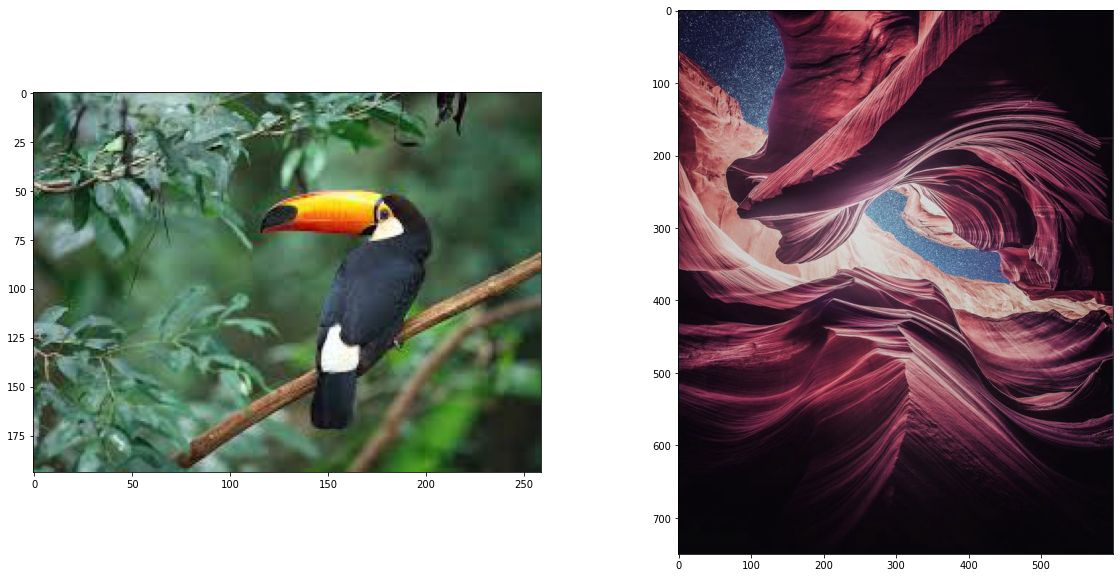

In [16]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

Get Content, style features and create gram matrix

In [20]:
def get_feature(image, model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', 
      '28' : 'conv5_1'
  }

  x = image
  Feature = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Feature[layers[name]] = x
  return Feature 

In [21]:
content_f = get_feature(content_p, vgg)
style_f = get_feature(style_p, vgg)

In [22]:
def gram_matrix(tensor):
  b, c,h,w = tensor.size()
  tensor = tensor.view(c, h * w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [23]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

Creating style and content loss function

In [24]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2- content_conv4_2) ** 2)
  return loss

In [25]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [31]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b, c, h, w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss / (c * h * w)

  return loss

In [32]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_feature(target, vgg)
print("Content Loss: ", content_loss(target_f['conv4_2'], content_f['conv4_2']))
print("Style Loss: ", style_loss(style_weights, target_f, style_grams))

Content Loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss:  tensor(9959.6328, device='cuda:0', grad_fn=<AddBackward0>)


Training Loop

In [34]:
from torch import optim
optimizer = optim.Adam([target], lr = 0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [35]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = (alpha*c_loss) + (beta*s_loss)
  return loss

In [38]:
result = []
for i in range(epochs):
  target_f = get_feature(target, vgg)

  s_loss = style_loss(style_weights, target_f, style_grams)
  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2']) 
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print("Total Loss at Epoch {}: {}".format(i, t_loss))
    result.append(deprocess(target.detach()))


Total Loss at Epoch 0: 995963264.0
Total Loss at Epoch 500: 263451792.0
Total Loss at Epoch 1000: 130153672.0
Total Loss at Epoch 1500: 97041512.0
Total Loss at Epoch 2000: 81256200.0
Total Loss at Epoch 2500: 71171856.0
